In [ ]:
# add torchvision to requirements

In [1]:
from PIL import Image
import cv2

In [2]:
import torch

In [3]:
import torchvision
from torchvision import transforms as T

In [6]:
import numpy as np
import matplotlib.pyplot as plt

In [9]:
DATA_PATH = '../../data/02_scenes/'

## Vid to Frames

In [7]:
def get_frame_durations(cap, fps):
    """A function that returns the list of durations where to save the frames"""
    
    # get the clip duration by dividing number of frames by the number of frames per second
    clip_duration = cap.get(cv2.CAP_PROP_FRAME_COUNT) / cap.get(cv2.CAP_PROP_FPS)
    
    # use np.arange() to make floating-point steps
    return np.arange(0, clip_duration, 1 / fps)

def split_video(video_file):
    
    # read in video   
    cap = cv2.VideoCapture(video_file)
    # get video FPS
    fps = min(cap.get(cv2.CAP_PROP_FPS), SAVING_FRAMES_PER_SECOND)

    # get the list of duration spots to save
    saving_frames_durations = get_frame_durations(cap, fps)
    
    # start the loop
    frames = []
    count = 0
    while True:
        is_read, frame = cap.read()
        if is_read:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
        else:
            break
        """if not is_read:
            # break out of the loop if there are no frames to read
            break
        # get the duration by dividing the frame count by the FPS
        frame_duration = count / fps
        try:
            # get the earliest duration to save
            closest_duration = saving_frames_durations[0]
        except IndexError:
            # the list is empty, all duration frames were saved
            break
        if frame_duration >= closest_duration:
            # if closest duration is less than or equals the frame duration, 
            # then save the frame
            frame_duration_formatted = format_timedelta(timedelta(seconds=frame_duration))
            cv2.imwrite(os.path.join(filename, f"frame{frame_duration_formatted}.jpg"), frame) 
            # drop the duration spot from the list, since this duration spot is already saved
            try:
                saving_frames_durations.pop(0)
            except IndexError:
                pass
        # increment the frame count
        count += 1"""
    return frames

In [10]:
SAVING_FRAMES_PER_SECOND = 30
cap_path = f'{DATA_PATH}atla_s1e1-Scene-151.mp4'
frames = split_video(cap_path)

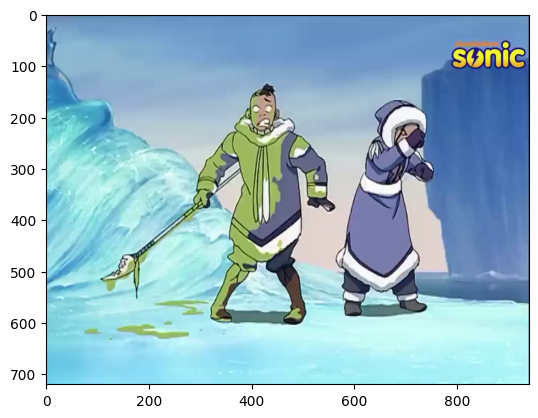

In [45]:
test_frame = frames[0]
plt.imshow(test_frame)

## Mask RCNN Model

In [4]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights = "DEFAULT")
model.eval()

transform = T.ToTensor()

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /Users/nathan.paull/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|████████████████████████████████████████| 170M/170M [00:23<00:00, 7.56MB/s]


In [46]:
ig = transform(test_frame)
with torch.no_grad():
    pred = model([ig])

In [47]:
pred[0].keys()

dict_keys(['boxes', 'labels', 'scores', 'masks'])

In [48]:
# label desc: https://tech.amikelive.com/node-718/what-object-categories-labels-are-in-coco-dataset/
masks = pred[0]["masks"]
labels = pred[0]['labels']
scores = pred[0]['scores']

In [49]:
scores

tensor([0.9989, 0.9822, 0.8452, 0.6195, 0.3254, 0.2706, 0.2557, 0.1225, 0.1097,
        0.0989, 0.0749, 0.0665, 0.0563, 0.0540])

tensor(0.9989)


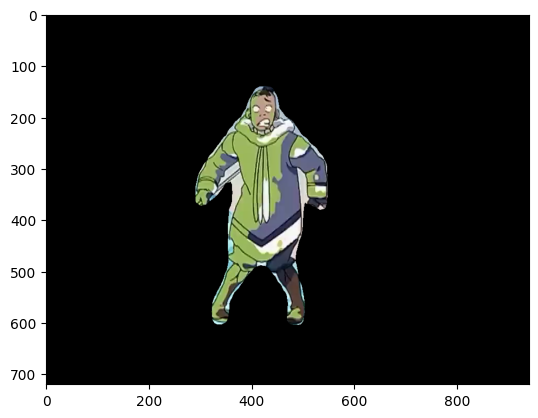

tensor(0.9822)


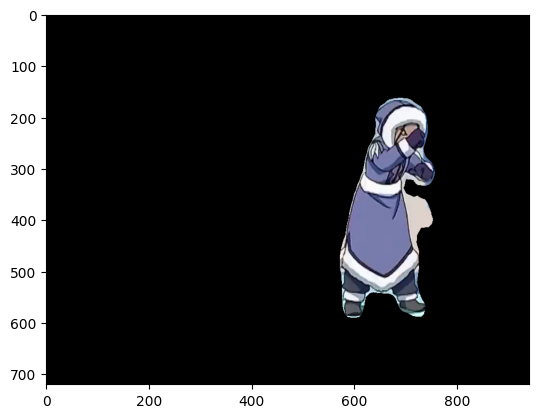

tensor(0.8452)


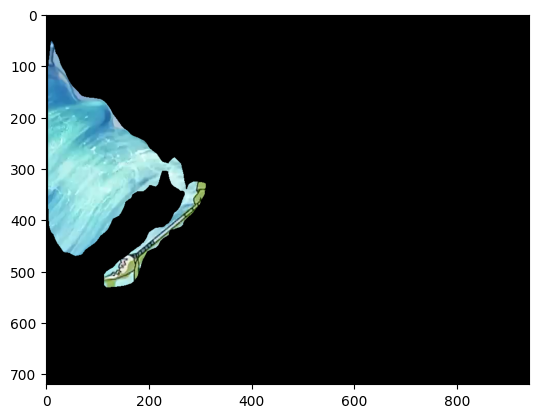

In [51]:
mask_conf = 0.4
cat_conf = 0.7

for n in range(masks.shape[0]):
    conf = scores[n]
    if conf<cat_conf:
        continue
    mask = (masks[n,0]>mask_conf).numpy().astype("uint8") * 255
    obj_img = cv2.bitwise_and(test_frame , test_frame , mask = mask)
    print(conf)
    plt.imshow(obj_img)
    plt.show()